Mẫu 1 chuổi tín hiệu ECG

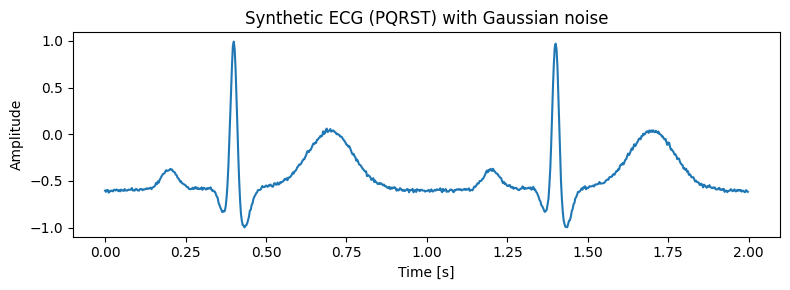

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(t, mu, sigma, amp):
    return amp * np.exp(-0.5 * ((t - mu) / sigma)**2)

def make_pqrst(fs=360, add_baseline=True, normalize=True):
    """
    Tạo 1 nhịp P-QRS-T dài 1 giây ở tần số lấy mẫu fs.
    """
    t = np.linspace(0, 1, fs, endpoint=False)
    # Hình thái đơn giản bằng tổng Gaussian (có thể tinh chỉnh tham số)
    beat = (
        gaussian(t, 0.20, 0.025, +0.12) +   # P
        gaussian(t, 0.37, 0.016, -0.15) +   # Q
        gaussian(t, 0.40, 0.010, +1.00) +   # R
        gaussian(t, 0.43, 0.020, -0.25) +   # S
        gaussian(t, 0.70, 0.070, +0.35)     # T
    )
    if add_baseline:
        beat = beat + 0.02 * np.sin(2*np.pi*0.5*t)  # baseline wander ~0.5 Hz
    if normalize:
        bmin, bmax = beat.min(), beat.max()
        if bmax > bmin:
            beat = (beat - bmin) / (bmax - bmin) * 2 - 1  # [-1, 1]
    return beat.astype(np.float32)

def synth_ecg(duration_s=2.0, bpm=60, fs=360, noise_std=0.01,
              add_baseline=True, normalize=True, seed=0, return_time=False):
    """
    Ghép nhiều nhịp để tạo đoạn ECG dài duration_s, thêm nhiễu Gaussian.
    """
    beat = make_pqrst(fs=fs, add_baseline=add_baseline, normalize=normalize)
    beats_needed = int(np.ceil(duration_s * bpm / 60.0))
    ecg = np.tile(beat, beats_needed)
    # cắt đúng độ dài yêu cầu (tính theo mẫu)
    n_samples = int(round(duration_s * fs))
    ecg = ecg[:n_samples]

    rng = np.random.default_rng(seed)
    if noise_std and noise_std > 0:
        ecg = ecg + rng.normal(0.0, noise_std, size=ecg.shape).astype(np.float32)

    if return_time:
        t = np.arange(n_samples, dtype=np.float32) / fs
        return t, ecg
    return ecg

# Ví dụ sử dụng
FS = 360
t, x = synth_ecg(duration_s=2.0, bpm=60, fs=FS, noise_std=0.01,
                 add_baseline=True, normalize=True, seed=42, return_time=True)

plt.figure(figsize=(8,3))
plt.plot(t, x)
plt.xlabel('Time [s]'); plt.ylabel('Amplitude')
plt.title('Synthetic ECG (PQRST) with Gaussian noise'); plt.tight_layout(); plt.show()


### Import relevant Packets

In [3]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning) #turn off irrelevant scipy future warning 
import heartbeat as hb
import normalizer
import importlib
import random 
import time 
import pandas as pd 
import numpy as np
from collections import Counter
from scipy import signal
from scipy.signal import find_peaks, resample
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
from os import listdir
from os.path import isfile, join
import sys
import warnings 
importlib.reload(hb)
importlib.reload(normalizer)

print('Packages Loaded')

Packages Loaded


### Datasets in Directory

In [4]:
print('Files in Directory {}:\n'.format(os.getcwd()+'/mit_data'))
print('-------------------------------\n')
onlyfiles = [f for f in listdir(os.getcwd()+'/mit_data') if isfile(join(os.getcwd()+'/mit_data', f))]
print(sorted(onlyfiles)[1:],'\n\n***',len(onlyfiles)-1,'data files ***')   

print('\nAll patients:\n',hb.all_patients())

Files in Directory d:\HOC_TAP\Đo_AN_2\ECG_Classification_Pytorch/mit_data:

-------------------------------

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt',

### All types of Heat Beat conditons from datasets

In [4]:
print("MIT DATABASES CONDITIONS:\n")
hb.classes_further

MIT DATABASES CONDITIONS:



{'N': 'Normal beat',
 'L': 'Left bundle branch block beat',
 'R': 'Right bundle branch block beat',
 'A': 'Atrial premature beat',
 'a': 'Aberrated atrial premature beat',
 'J': 'Nodal (junctional) premature beat',
 'S': 'Supraventricular premature beat',
 'V': 'Premature ventricular contraction',
 'F': 'Fusion of ventricular and normal beat',
 '[': 'Start of ventricular flutter/fibrillation',
 '!': 'Ventricular flutter wave',
 ']': 'End of ventricular flutter/fibrillation',
 'e': 'Atrial escape beat',
 'j': 'Nodal (junctional) escape beat',
 'E': 'Ventricular escape beat',
 '/': 'Paced beat',
 'f': 'Fusion of paced and normal beat',
 'x': 'Non-conducted P-wave (blocked APB)',
 'Q': 'Unclassifiable beat',
 '|': 'Isolated QRS-like artifact'}

## Top K = 8 Most common condition from data + Count

In [5]:
hb.most_common_conditions(patients=hb.all_patients(),top_k=8)

[('N', 75052),
 ('L', 8075),
 ('R', 7259),
 ('V', 7130),
 ('/', 7028),
 ('A', 2546),
 ('+', 1291),
 ('f', 982)]

### Class we will be exxaming

In [5]:
print('Specific_classes to be examined:\n')
classes= {0:'N',1:'L',2:'R',3:'V',4:'/',5:'A',6:'f',7:'F'}
print(classes,'\n')
for k,v in classes.items():
    print('Class {} condition: {}'.format(k+1,hb.classes_further[v]))

Specific_classes to be examined:

{0: 'N', 1: 'L', 2: 'R', 3: 'V', 4: '/', 5: 'A', 6: 'f', 7: 'F'} 

Class 1 condition: Normal beat
Class 2 condition: Left bundle branch block beat
Class 3 condition: Right bundle branch block beat
Class 4 condition: Premature ventricular contraction
Class 5 condition: Paced beat
Class 6 condition: Atrial premature beat
Class 7 condition: Fusion of paced and normal beat
Class 8 condition: Fusion of ventricular and normal beat


Plot Diagram

Generating_plot(s)...


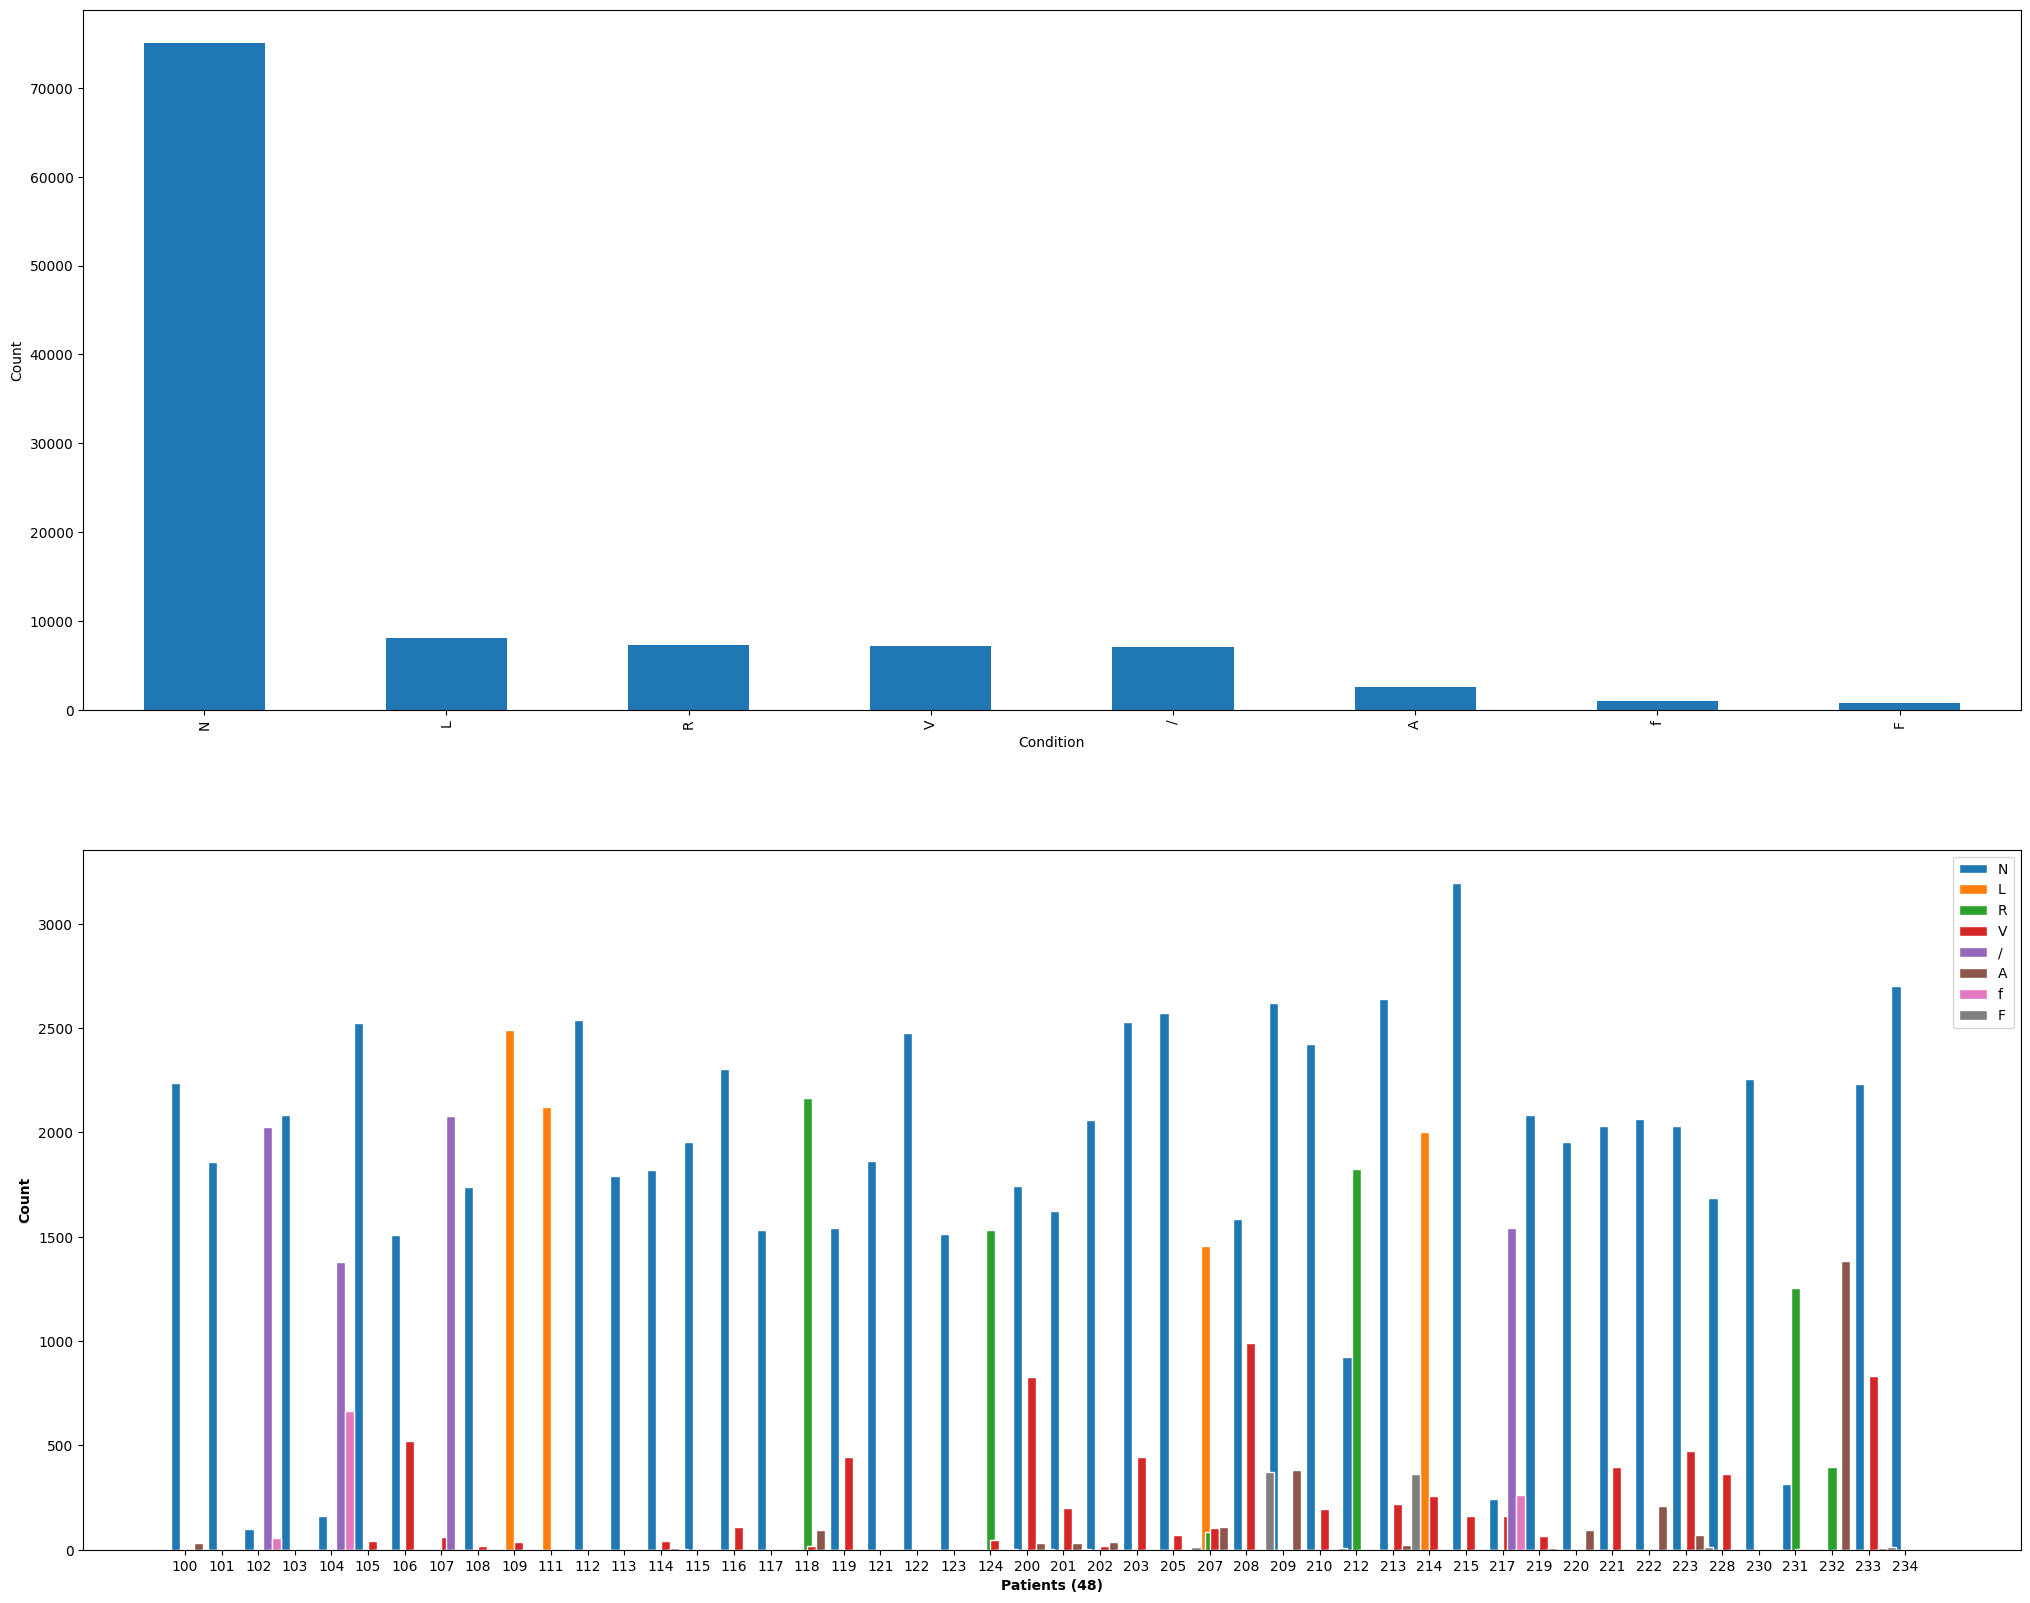

In [7]:
classes= {0:'N',1:'L',2:'R',3:'V',4:'/',5:'A',6:'f',7:'F'}
patient_dic=hb.distribution_bar(patients=hb.all_patients(),classes=classes)

### Reduce the Number of Classes, not all patients are represented (Creat a connecting Dictionary)

In [6]:
classes= {0:'N',1:'S',2:'V',3:'F',4:'Q'}
classes_reducer={'N':['N','L','R','e','j'],
                 'S':['S','A','a','J'],'V':['V','E'],'F':['F'],'Q':['/','Q','f']}
for c, subclass in classes_reducer.items():
    print('For class:',c, '({})'.format(hb.classes_further[c]))
    for i in subclass:
        print("  ({})".format(i), hb.classes_further[i])

For class: N (Normal beat)
  (N) Normal beat
  (L) Left bundle branch block beat
  (R) Right bundle branch block beat
  (e) Atrial escape beat
  (j) Nodal (junctional) escape beat
For class: S (Supraventricular premature beat)
  (S) Supraventricular premature beat
  (A) Atrial premature beat
  (a) Aberrated atrial premature beat
  (J) Nodal (junctional) premature beat
For class: V (Premature ventricular contraction)
  (V) Premature ventricular contraction
  (E) Ventricular escape beat
For class: F (Fusion of ventricular and normal beat)
  (F) Fusion of ventricular and normal beat
For class: Q (Unclassifiable beat)
  (/) Paced beat
  (Q) Unclassifiable beat
  (f) Fusion of paced and normal beat


### Classes_reducer is optional argument that can be used to link one class to another
#### Patient_dic is a dictionary that has relevant class proportion inforation

Generating_plot(s)...


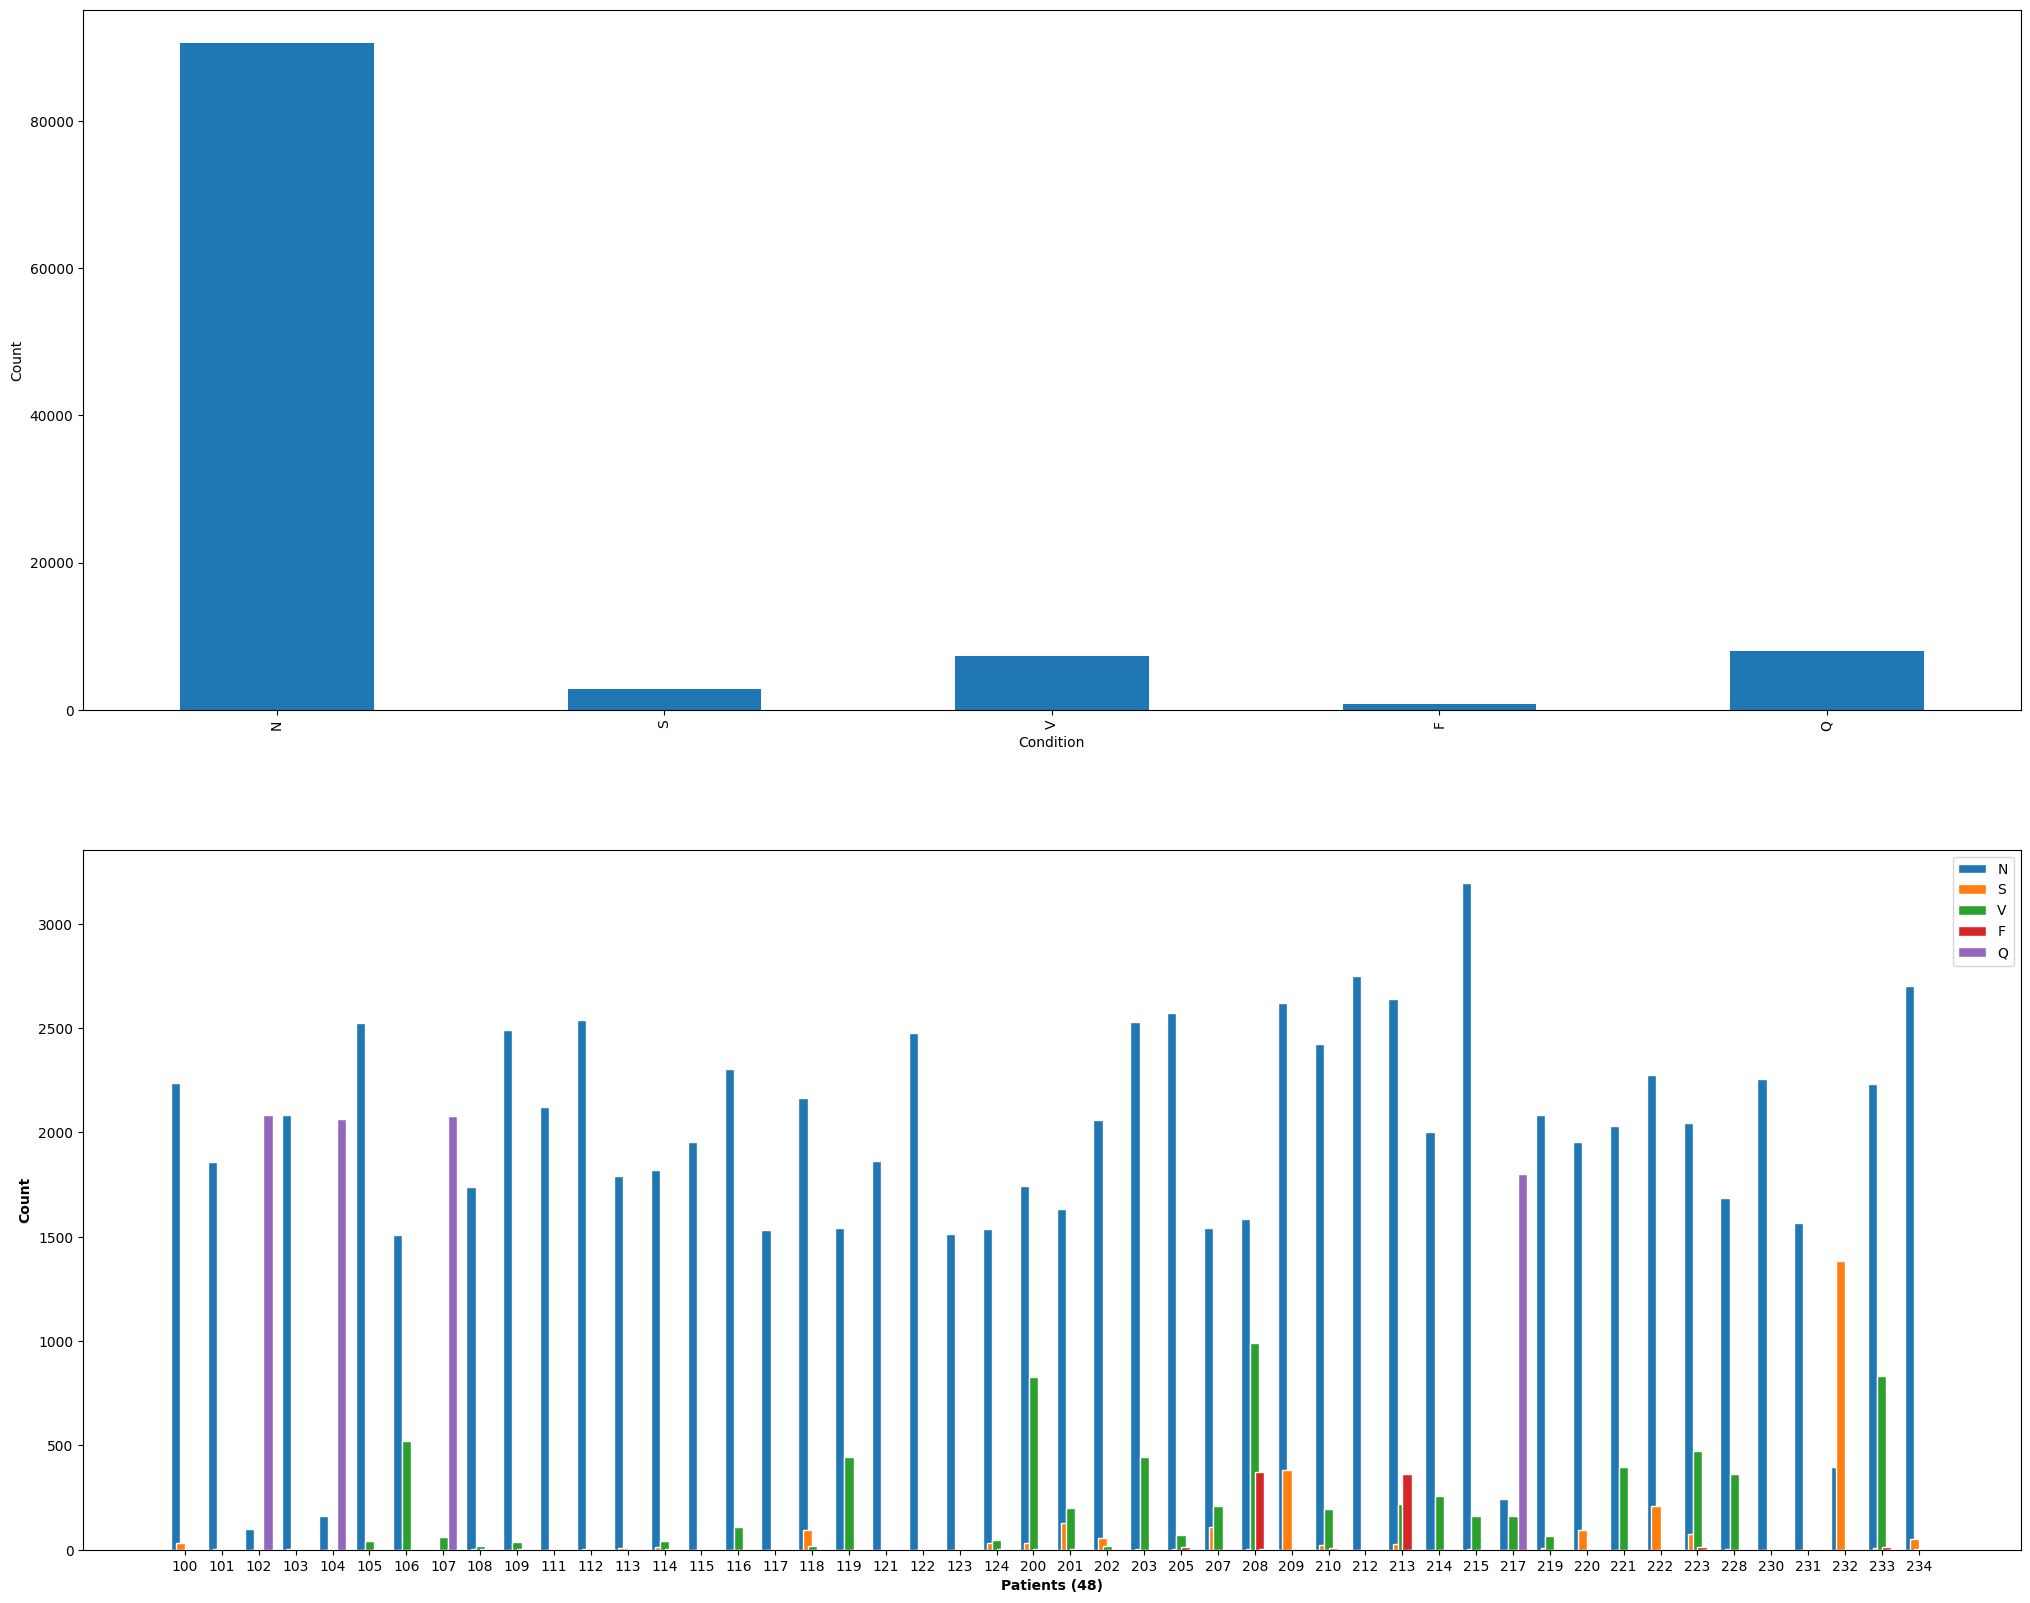

In [9]:
patient_dic=hb.distribution_bar(patients=hb.all_patients(),classes=classes,
                                classes_reducer=classes_reducer)

We notice a better distribution with joined classes, if we remove normal condition we can see this a little more cleary

Generating_plot(s)...


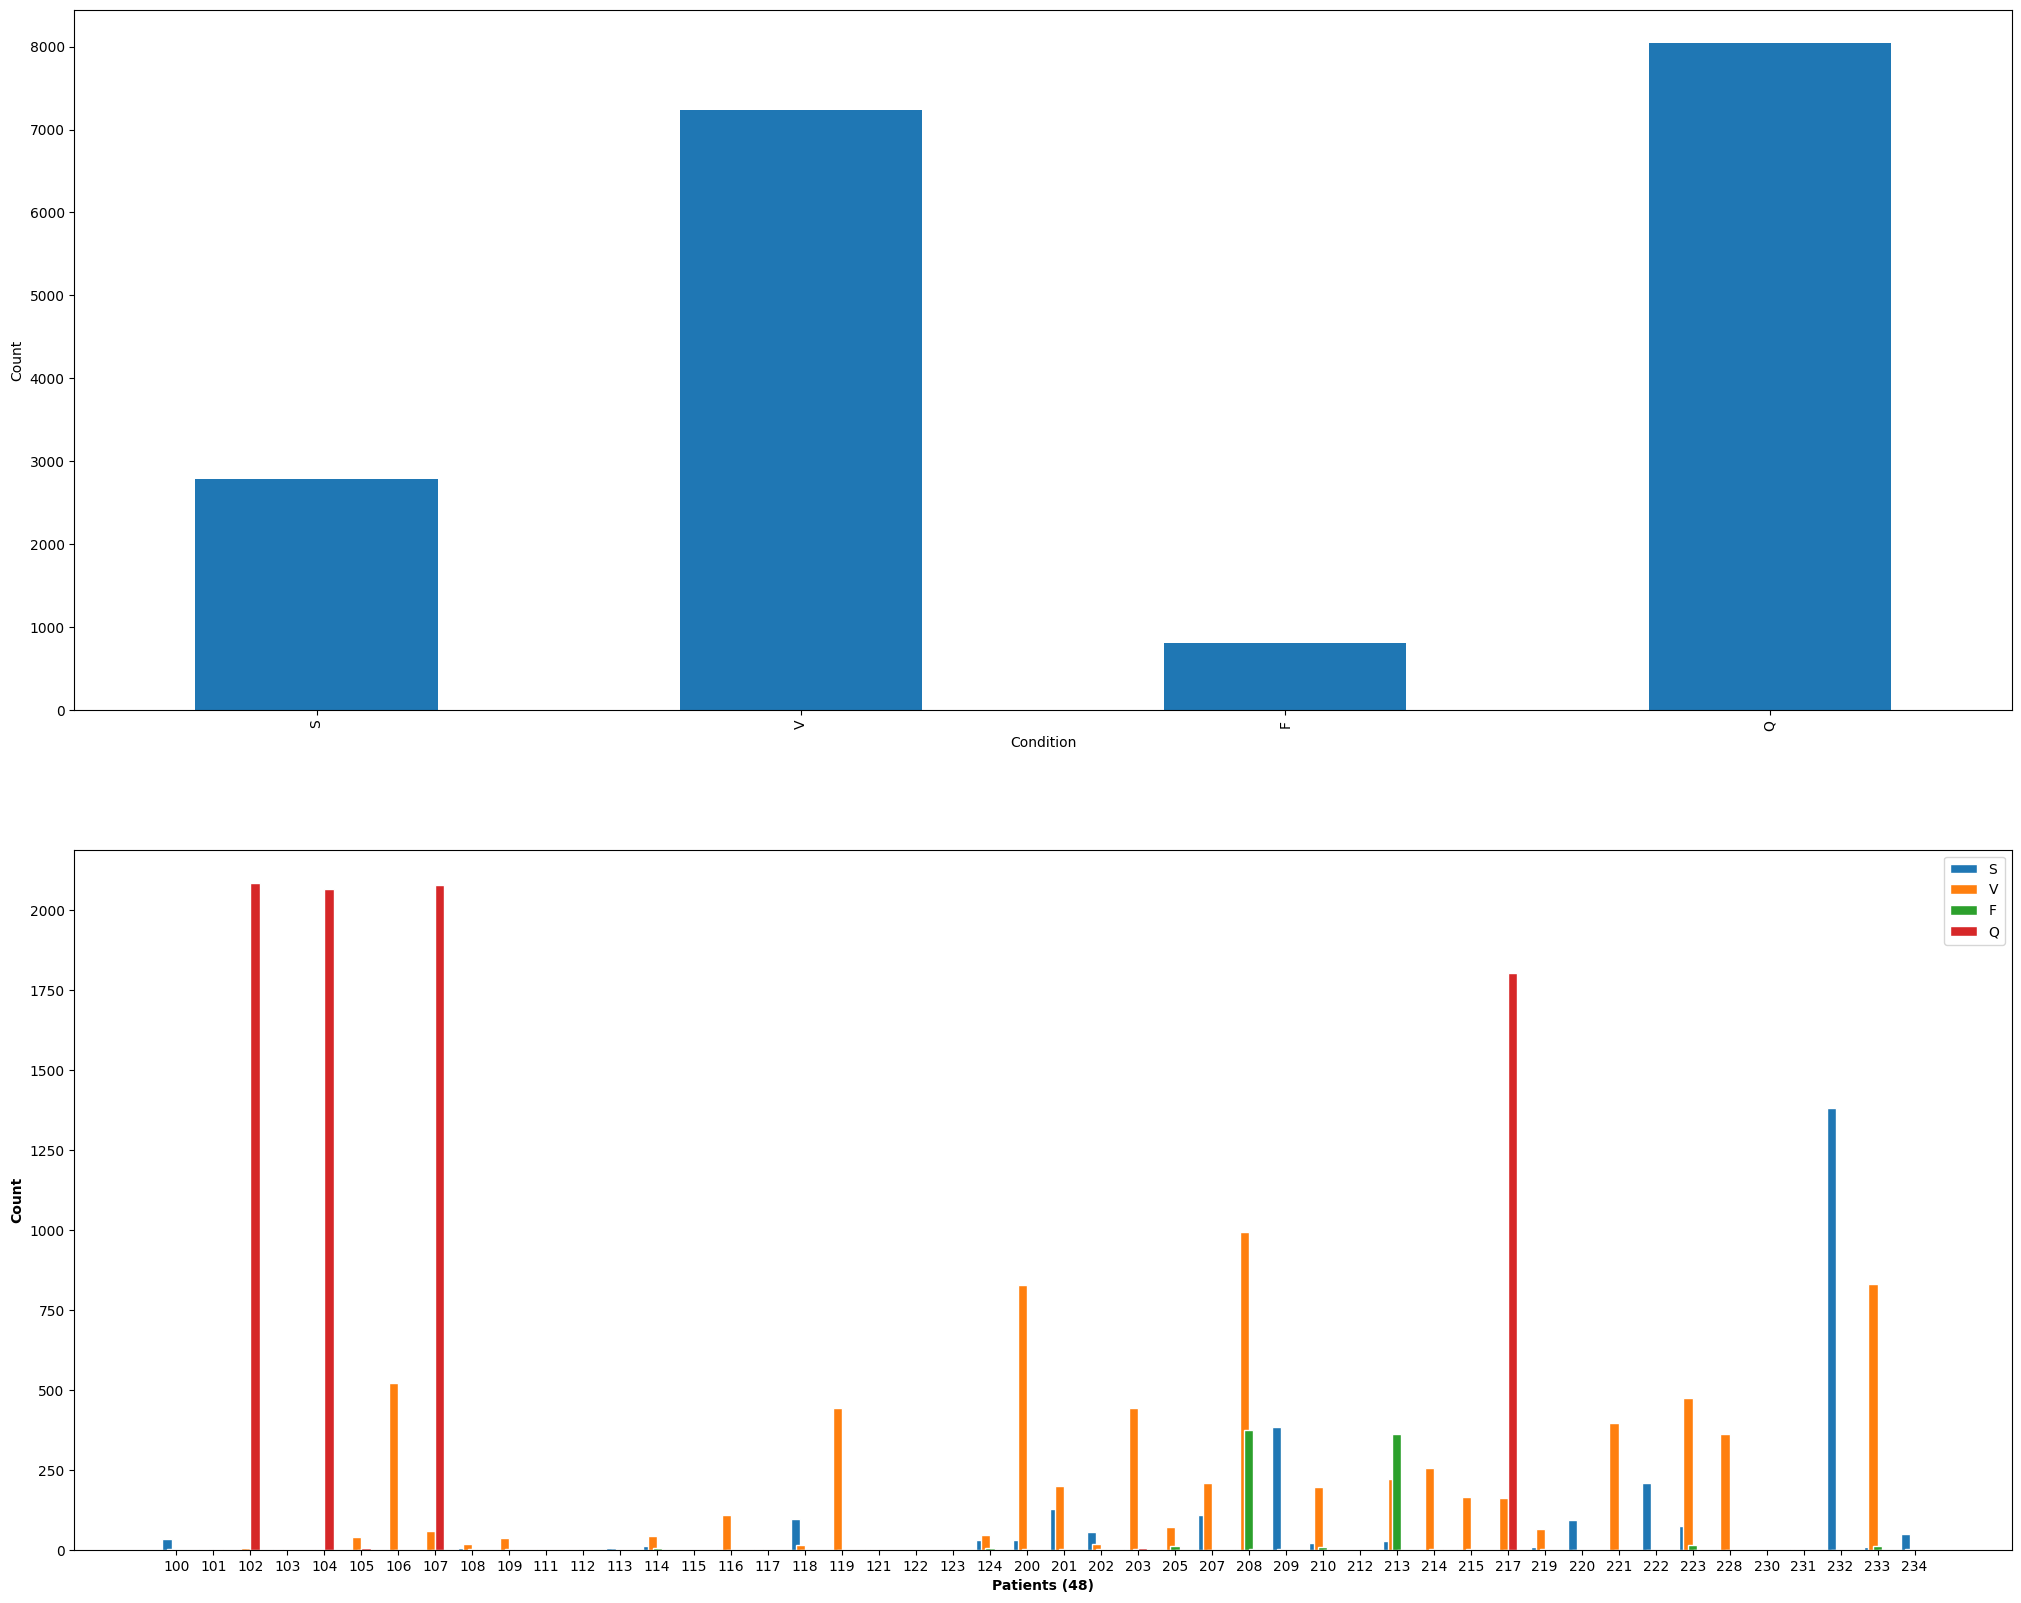

In [10]:
classes_wo_N= {0:'S',1:'V',2:'F',3:'Q'}
patient_dic=hb.distribution_bar(patients=hb.all_patients(),classes=classes_wo_N,
                                classes_reducer=classes_reducer)

### Random Example heart rate beat

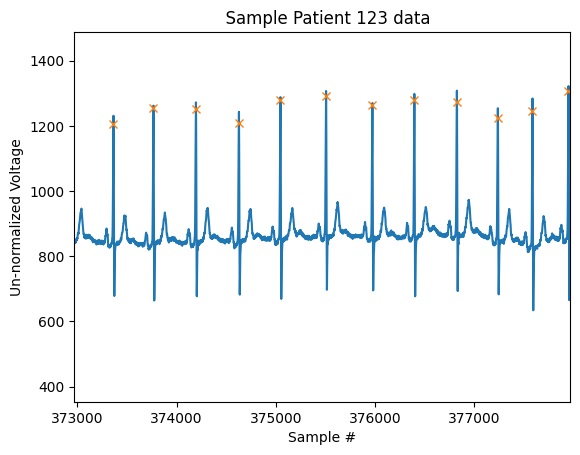

In [9]:
patient=random.choice(hb.all_patients())
hb.get_patient_data(patient,norm=False,sample_plot=True)
plt.ylabel('Un-normalized Voltage')
plt.xlabel('Sample #')
plt.draw()

In [10]:
signal,ecg_notes=hb.get_patient_data(patient=101,norm=False,sample_plot=False)
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

print("Labeled Heart Beats  | Signal Data")
display_side_by_side(ecg_notes.head(),signal.to_frame().head())

Labeled Heart Beats  | Signal Data


sample_num 
 type 
 aux 
 
 
 
 
 0 
 7 
 + 
 (N 
 
 
 1 
 83 
 N 
 NaN 
 
 
 2 
 396 
 N 
 NaN 
 
 
 3 
 711 
 N 
 NaN 
 
 
 4 
 1032 
 N 
 NaN 
 
 
 
 
 
 
 signal 
 
 
 
 
 0 
 955 
 
 
 1 
 955 
 
 
 2 
 955 
 
 
 3 
 955 
 
 
 4 
 955

### Examining the best Techniques to Normalizing data
`hb.moving_average`: Numpy base moving average function.<br>
- Input: signal and windown size <br>
- Output: averaged signal <br>

- Dùng để chuẩn hóa tín hiệu, làm tín hiệu mượt mà hơn cho bước tiếp theo

PATIENT: 217

Norm 1: Creates a mean of 0, and a std of 1
Norm 2: Creates a mean of 0, and y range from [-1 1]
Norm 3: Creates a y range from [0 1]


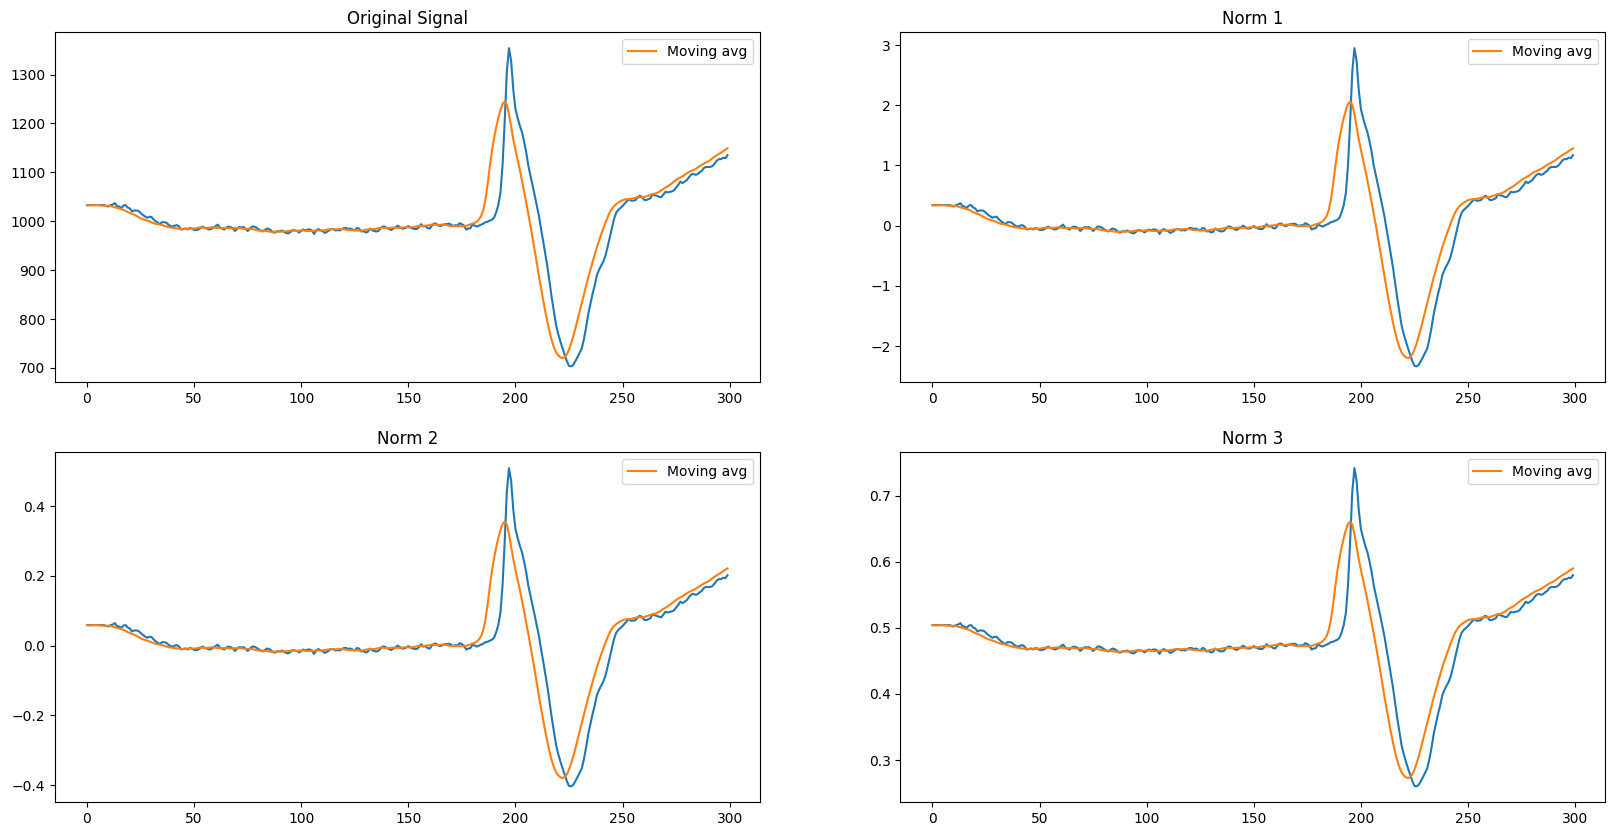

Selected Norm = 3


In [11]:
patient=random.choice(hb.all_patients())
import numpy as np
import matplotlib.pyplot as plt
def compare(patient,length,window=10):
    print("PATIENT: {}\n".format(patient))
    sig,notes= hb.get_patient_data(patient,norm=False)
    m=hb.moving_average(sig,10)
    n = np.random.choice(10*length)
    plt.figure(figsize=(20,10))
    
    plt.subplot(221)
    plt.plot(sig[0:length])
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Original Signal')
    
    
    print("Norm 1: Creates a mean of 0, and a std of 1")
    plt.subplot(222)
    plt.plot(normalizer.z_norm_b(sig)[0:length])
    m=hb.moving_average(normalizer.z_norm_b(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Norm 1')
    
    print("Norm 2: Creates a mean of 0, and y range from [-1 1]")
    plt.subplot(223)
    plt.plot(normalizer.z_norm2(sig)[0:length])
    m=hb.moving_average(normalizer.z_norm2(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Norm 2')

    
    print("Norm 3: Creates a y range from [0 1]")
    plt.subplot(224)
    plt.plot(normalizer.z_norm(sig)[0:length])
    m=hb.moving_average(normalizer.z_norm(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Norm 3')
    plt.show()
    
compare(patient=patient,length=300)
print('Selected Norm = 3')

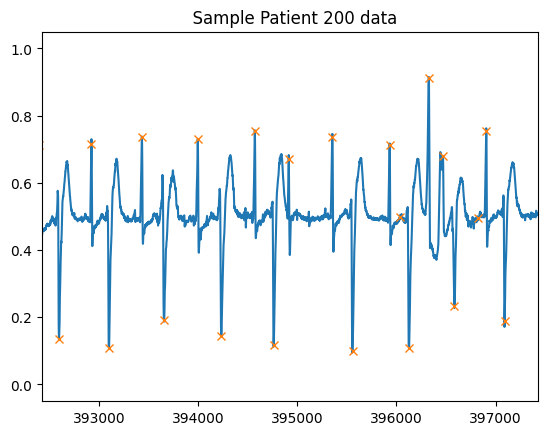

In [12]:
hb.get_patient_data(patient=200,norm=True,sample_plot=True)

### Norm 3 selected and used to normalize data
`hb.get_petient_data()` with norm flag = true

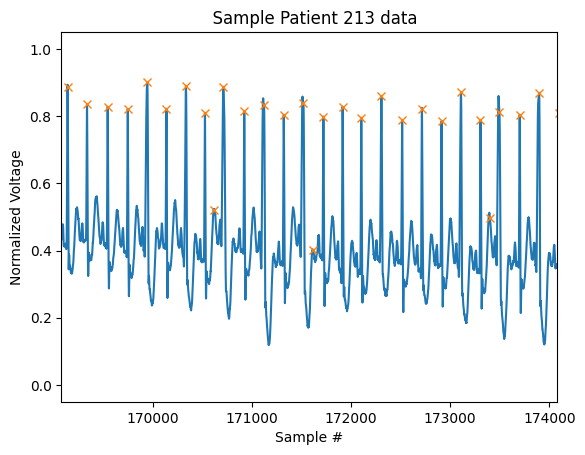

In [13]:
patient=random.choice(hb.all_patients())

hb.get_patient_data(patient,norm=True,sample_plot=True)
plt.ylabel('Normalized Voltage')
plt.xlabel('Sample #')
plt.draw()

### Examing relevant of frequency in model
#### Run cell as many times as you like to see how different patients look like

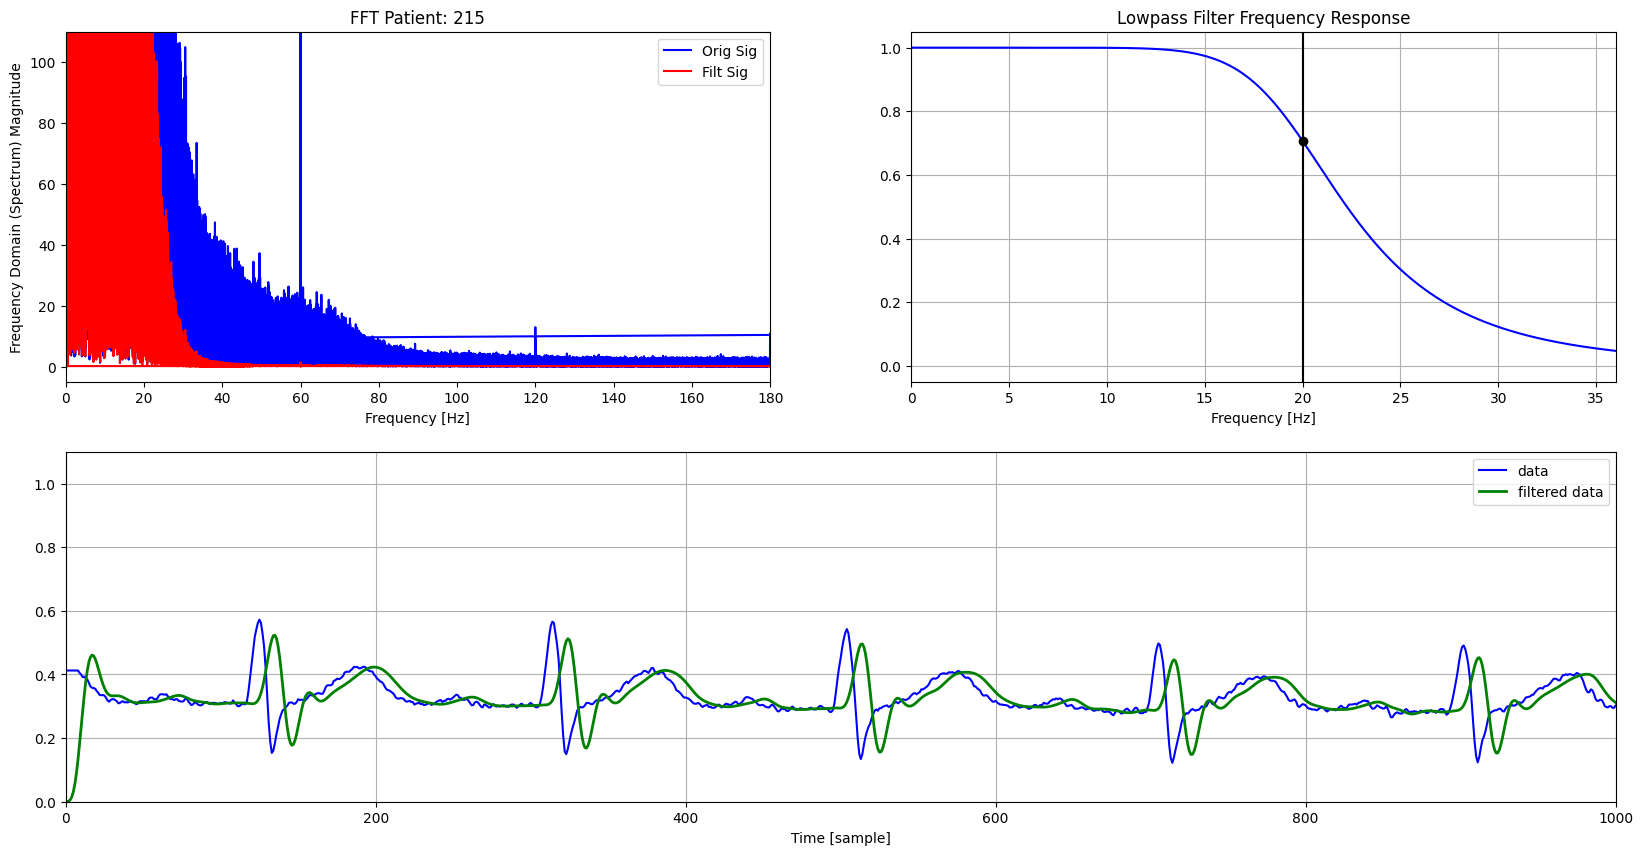

In [14]:
import importlib, normalizer
importlib.reload(normalizer)
from normalizer import filt
patient = random.choice(hb.all_patients())
filt().low_pass_filter_plot(patient=patient, cutoff=20, fs=360)

### Heart beat isolation Algorithm 
<br>- Hàm này biến dữ liệu dài liên tục thành các mẫu beat rời rạc đồng bộ theo R-peak

Examining 48 patients...
Percent: [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00% Done...

Padding...


Average HR Sample Len: 284.39 samples (0.79s per beat)
Average HR: 80.61 bpm
Plotting...



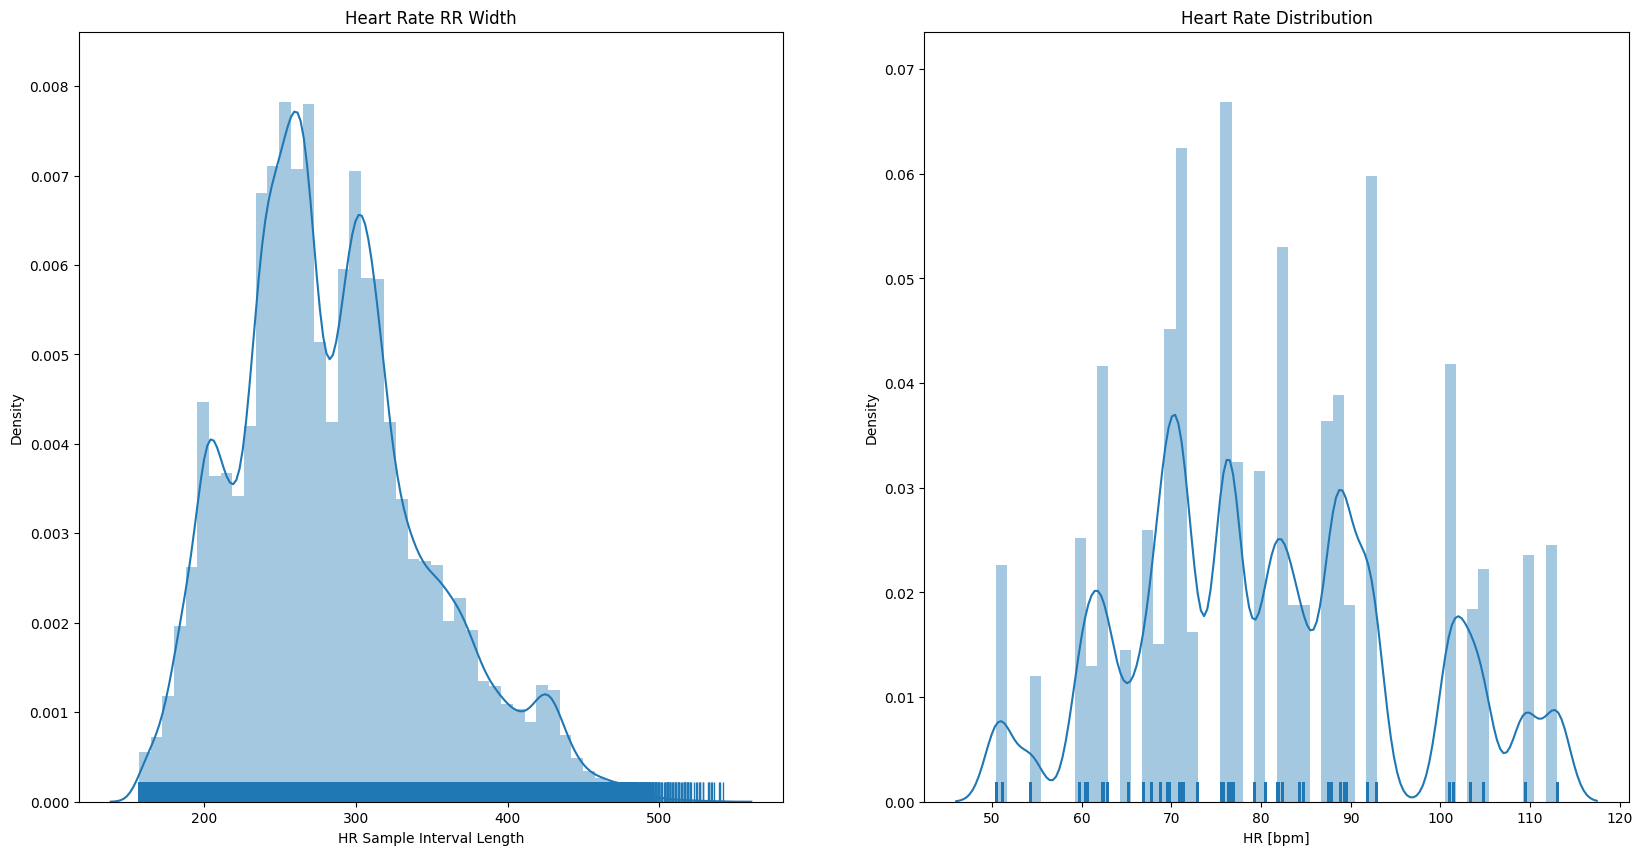

Data Loaded | Shape:(107726, 542)

    89696 cases of Normal beat

    2388 cases of Supraventricular premature beat

    6827 cases of Premature ventricular contraction

    8028 cases of Unclassifiable beat

    787 cases of Fusion of ventricular and normal beat

3.48min Runtime


In [15]:
#isolation algorithim heart beat data 
X,y,isolated_beat= hb.isolate_patient_data(patients=hb.all_patients(),classes=classes,
                    classes_further=hb.classes_further, classes_reducer=classes_reducer, 
                     min_HR= 40,max_HR= 140,fs=360,verbose=False,plot_figs=True)

In [16]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("sample y vals:: [patient#, HR, Condition Class]:",y[0])

X shape: (107726, 539)
y shape: (107726, 3)
sample y vals:: [patient#, HR, Condition Class]: ['100' '75.536676138855' 'N']


### Looking into Isolated Heart beats
- Vẽ các nhịp mẫu theo từng lớp

MAX HB TIME: 1.4972222222222222


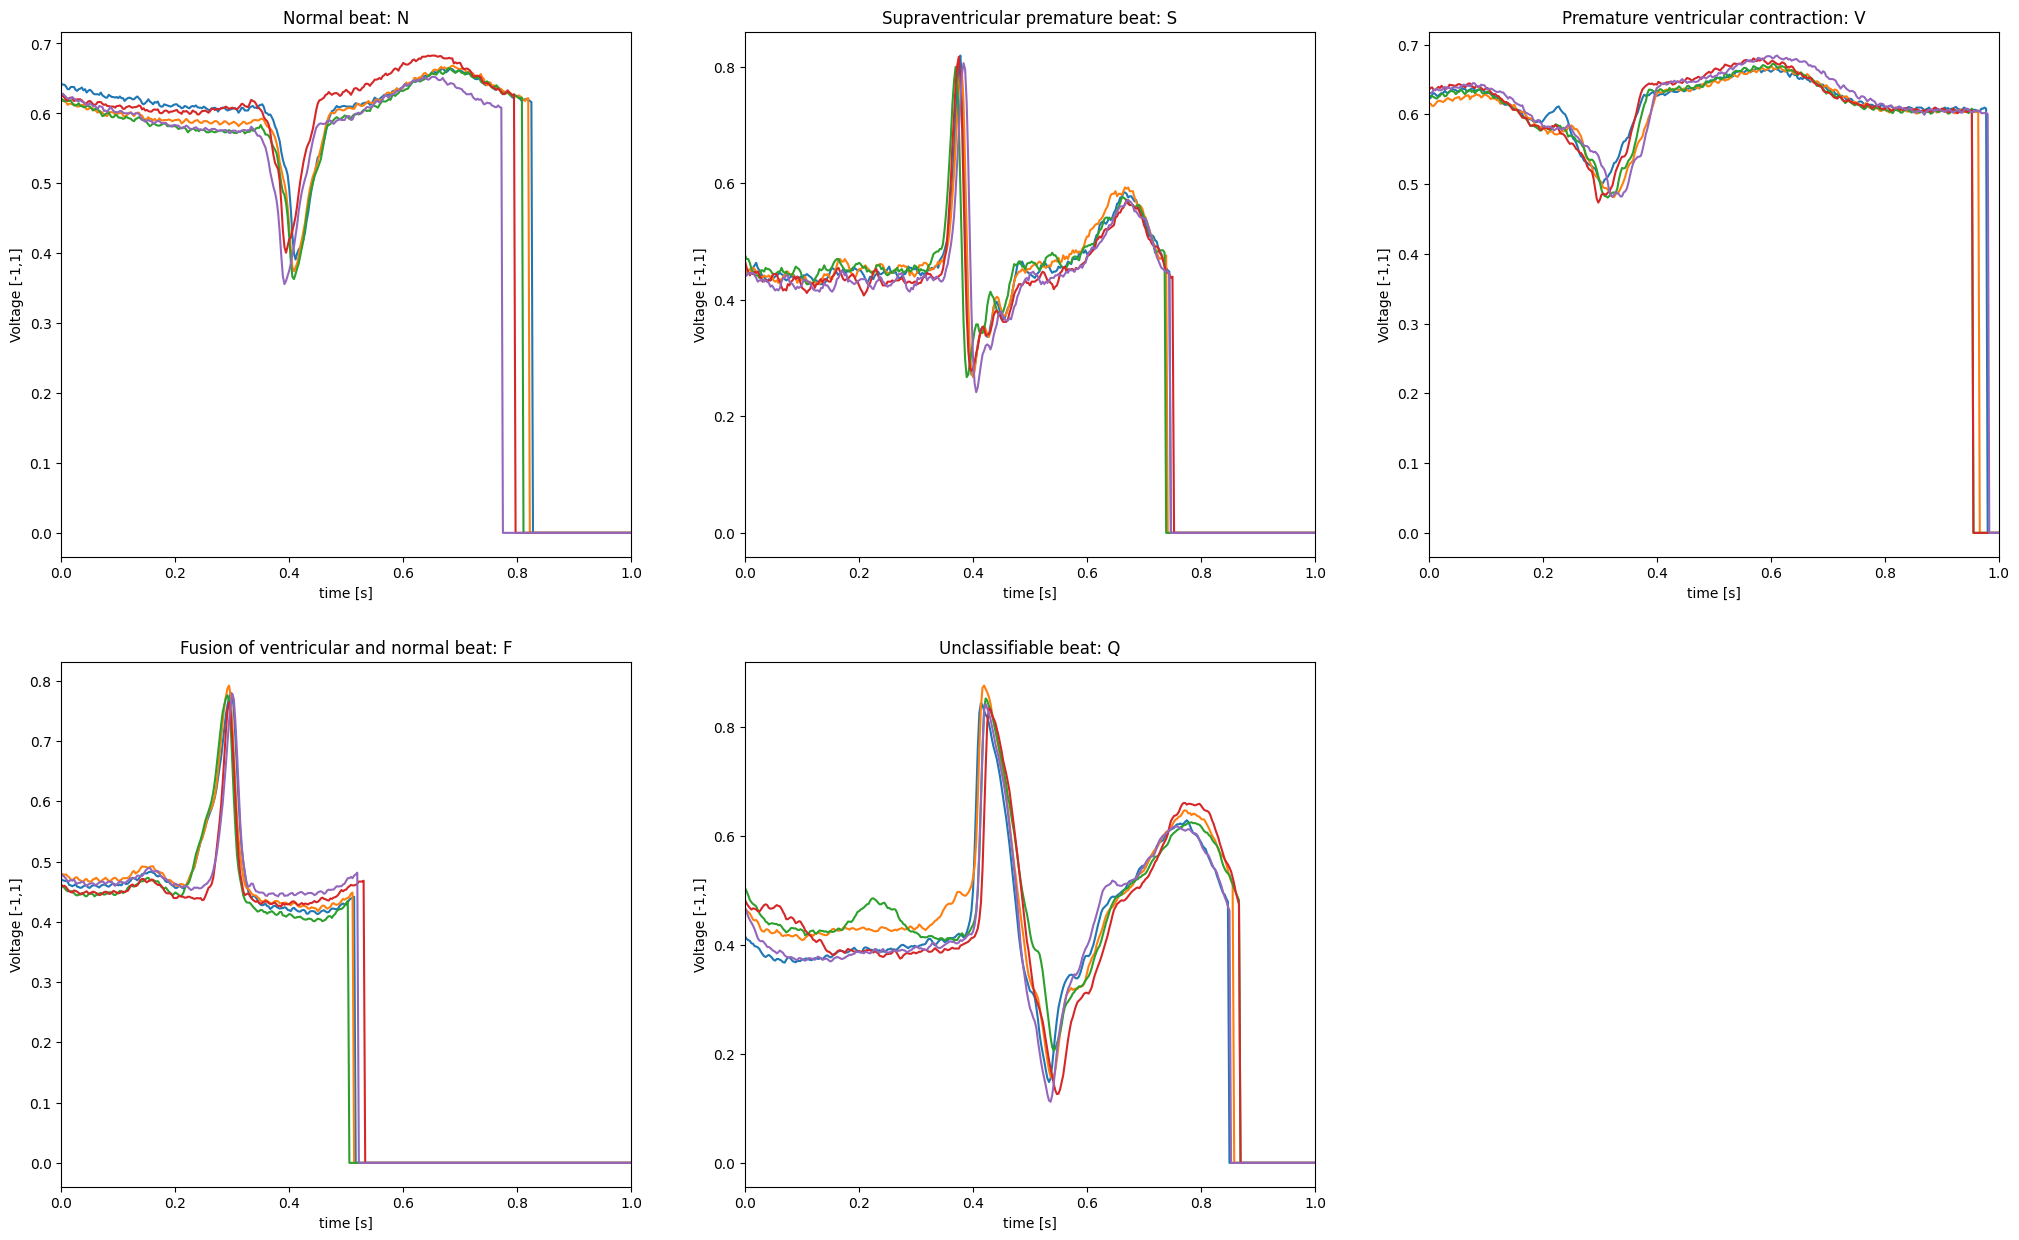

In [17]:
hb.show_sample_plots(X=X,y=y,classes=classes,classes_further=hb.classes_further,plot_xlim=1,dims=[2,3])

### Resampling 360Hz 
<br> How many data points do we need with out losing too much information per signal

In [18]:
# Cut Roughly in Half 
print('Resampling...\n')
X_resamp=hb.resample_vals(X,samp_len=187)
print("X_resamp shape:", X_resamp.shape)
print("y shape:", y.shape)

Resampling...

X_resamp shape: (107726, 187)
y shape: (107726, 3)


### How resampling looks like (looking at about 1/2 second)
 
### Signal are all presentes with out the model getting to occupied with to much data 

MAX HB TIME: 0.5194444444444445


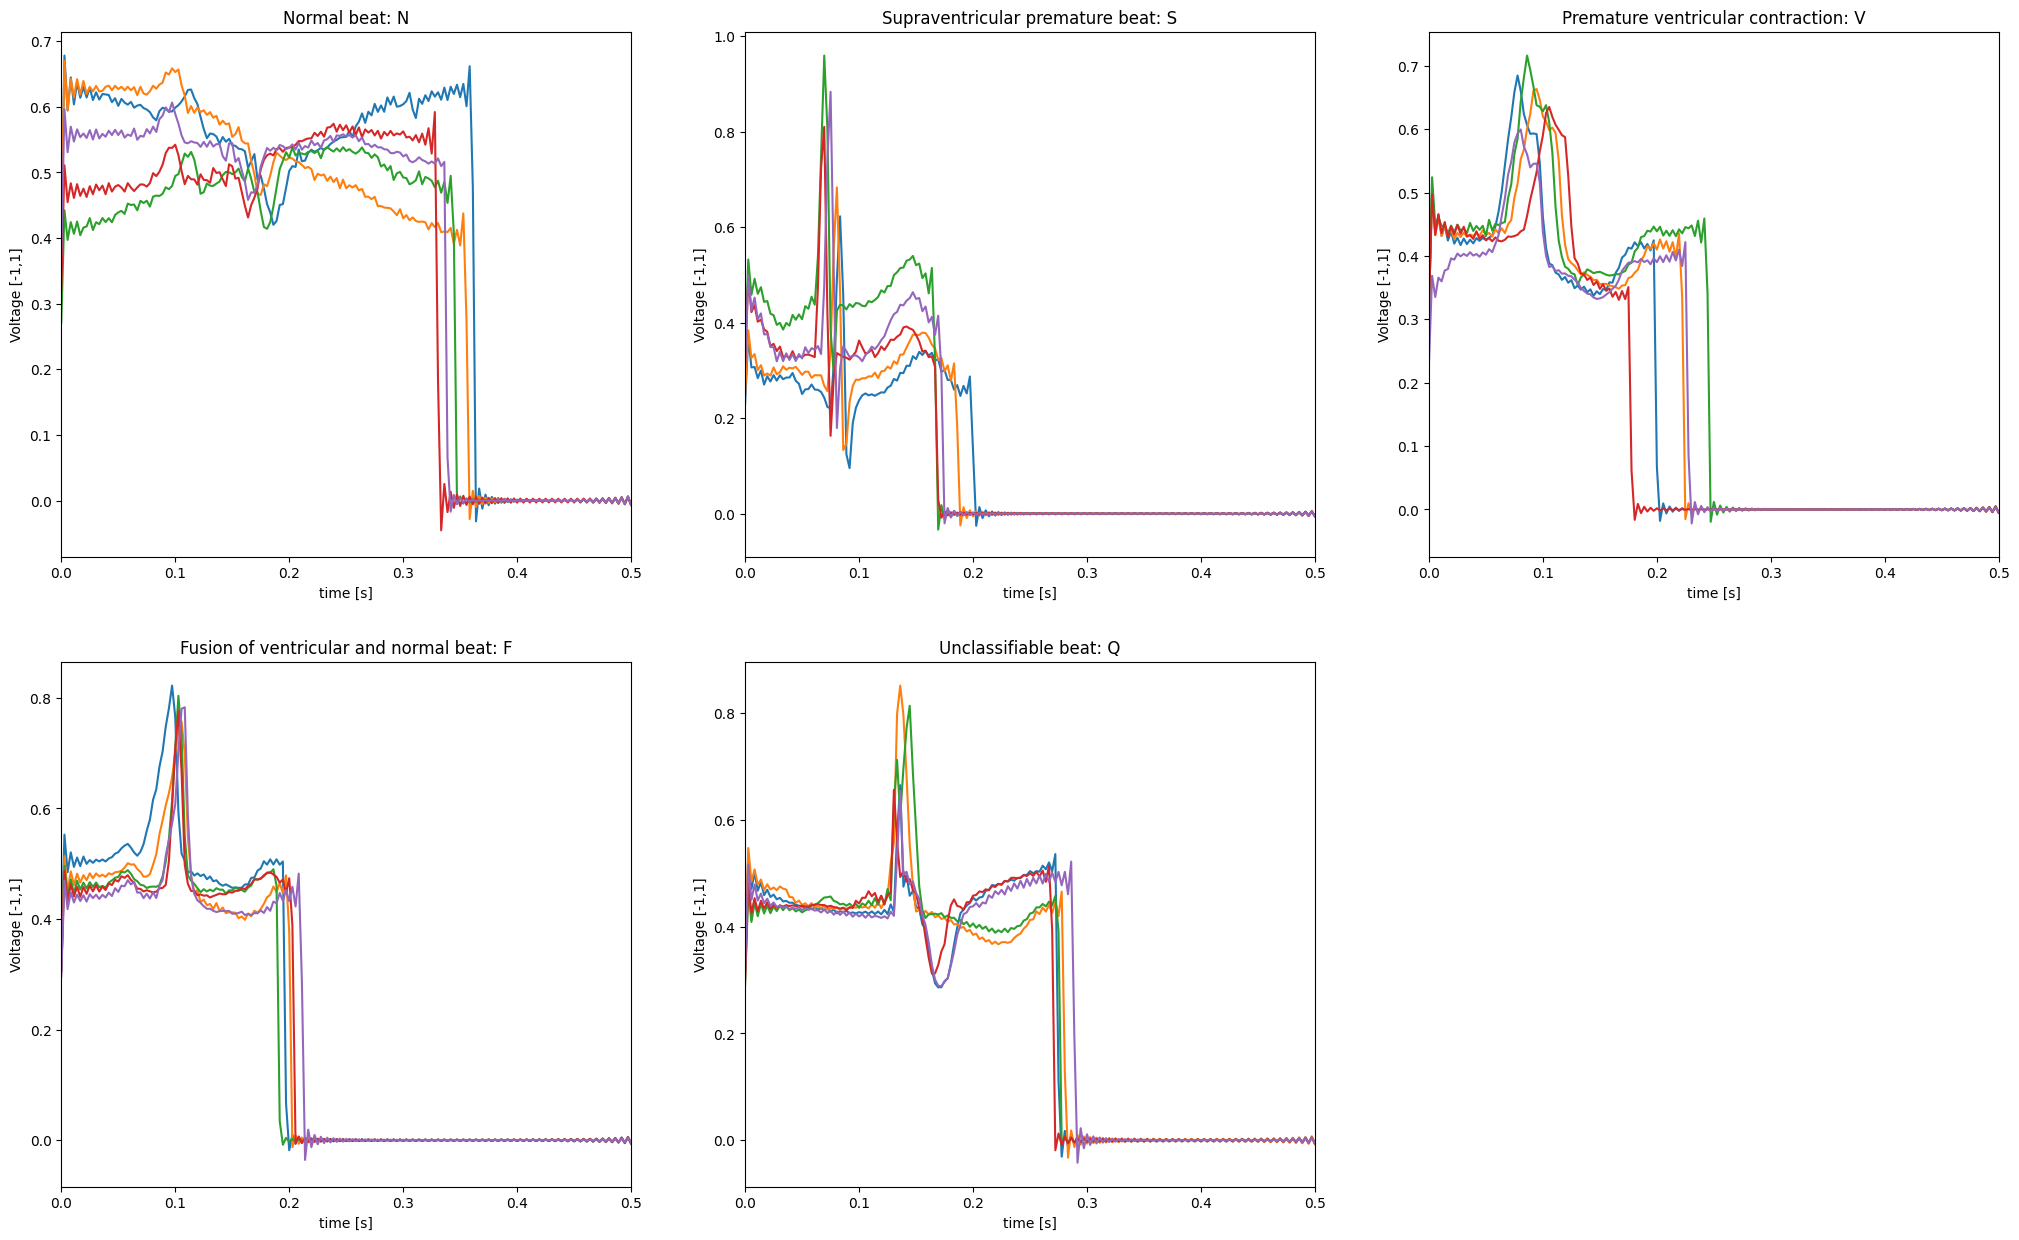

In [19]:
hb.show_sample_plots(X=X_resamp,y=y,classes=classes,classes_further=hb.classes_further,
                     plot_xlim=.5,dims=[2,3])

### Lets save X,Y and use Torch to see how the model performs on a deep learning work using Colab GPU

In [20]:
pd.DataFrame(y).to_csv("D:\HOC_TAP\Đo_AN_2\ECG_Classification_Pytorch/X_resamped.csv")

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\dellc\AppData\Local\Temp\ipykernel_1720\3274334121.py:1: SyntaxWarning: invalid escape sequence '\H'
  pd.DataFrame(y).to_csv("D:\HOC_TAP\Đo_AN_2\ECG_Classification_Pytorch/X_resamped.csv")


In [21]:
pd.DataFrame(y).to_csv("D:\HOC_TAP\Đo_AN_2\ECG_Classification_Pytorch/y.csv")

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\dellc\AppData\Local\Temp\ipykernel_1720\131970714.py:1: SyntaxWarning: invalid escape sequence '\H'
  pd.DataFrame(y).to_csv("D:\HOC_TAP\Đo_AN_2\ECG_Classification_Pytorch/y.csv")


### Upload data

In [22]:
classes={0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
print('X (resampled):',X_resamp.shape,'y:',y.shape,'Classes:',classes)

def get_key(val,my_dict): 
    """
    Simple Function to Get Key 
    in Dictionary from val. 
    
    Input: Key, Dictionary 
    Output: Val
    
    """
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
    return "key doesn't exist"

def one_hot(c,classes=classes):
    """
    Simple one hot encoding for the 
    types of arrthymia conditions. 
    
    class --> encode class
    'N' --> [1, 0, 0, 0, 0, 0, 0, 0]
    
    c:: current class of the object
    classes:: classes dictionary 
        
    """
    enc=np.zeros(len(classes),dtype=int).tolist()
    enc[get_key(c,classes)]= 1
    return enc
  
all_patients=['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
              '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
              '222', '223', '228', '230', '231', '232', '233', '234']

X (resampled): (107726, 187) y: (107726, 3) Classes: {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}


### Dividing and Prepping data for DL 

In [23]:
from sklearn.utils import shuffle
def get_train_test(X,y,train_size,classes=classes,patients=all_patients):
  """
  Get train and test function for spliting ensuring testing has all classes
  preseting for testing/eval to see how well all classes are performing. 
  """

  sub_c={}
    
 
  for c in classes:
      C = np.argwhere(y[:,2] == list(classes.values())[c]).flatten()

      sub_c[c]=np.random.choice(C,int((C.shape[0]- C.shape[0]*train_size)))

  X_test = np.vstack([X[sub_c[0]], X[sub_c[1]], X[sub_c[2]], X[sub_c[3]], X[sub_c[4]]])
  y_test = np.vstack([y[sub_c[0]], y[sub_c[1]], y[sub_c[2]], y[sub_c[3]], y[sub_c[4]]])

  deletions=[]
  for i in range(len(sub_c)):
    deletions.extend(sub_c[i].tolist())
  
  X_train = np.delete(X, deletions, axis=0)
  y_train = np.delete(y, deletions, axis=0)

  X_train, y_train = shuffle(X_train, y_train, random_state=0)
  X_test, y_test = shuffle(X_test, y_test, random_state=0)
  y_train= np.array([get_key(y_i,classes) for y_i in y_train[:,2]])
  y_test= np.array([get_key(y_i,classes) for y_i in y_test[:,2]])
  return X_train,y_train,X_test,y_test

  

X_train,y_train,X_test,y_test=get_train_test(X=X_resamp,y=y,train_size=.80)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
  

X_train: (88159, 187)
y_train: (88159,)
X_test: (21543, 187)
y_test: (21543,)


### Get Train, Validation, Test Loader

In [24]:
import os, numpy as np, torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler, SubsetRandomSampler

# --- 0) Khóa random cho tái lập ---
def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# --- 1) Pre-flight: kiểm tra dữ liệu & nhãn ---
def sanity_check(X_tr, y_tr, X_te, y_te, expected_num_classes=None):
    X_tr = np.asarray(X_tr); X_te = np.asarray(X_te)
    y_tr = np.asarray(y_tr).reshape(-1).astype(np.int64)
    y_te = np.asarray(y_te).reshape(-1).astype(np.int64)

    assert len(X_tr) == len(y_tr) and len(X_te) == len(y_te), "X/y length mismatch"
    assert np.isfinite(X_tr).all() and np.isfinite(X_te).all(), "NaN/Inf in X"

    u_tr, c_tr = np.unique(y_tr, return_counts=True)
    u_te, c_te = np.unique(y_te, return_counts=True)
    print("Train classes:", dict(zip(u_tr.tolist(), c_tr.tolist())))
    print("Test  classes:", dict(zip(u_te.tolist(), c_te.tolist())))

    K = int(max(u_tr.max(), u_te.max())) + 1
    if expected_num_classes is not None:
        assert K == expected_num_classes, f"Classes detected={K} != expected={expected_num_classes}"
    assert y_tr.min() >= 0 and y_te.min() >= 0, "Negative label found"
    # Nhãn phải nằm trong [0..K-1] liên tục
    assert set(u_tr).issubset(set(range(K))) and set(u_te).issubset(set(range(K))), "Labels not in 0..K-1"

    return (X_tr.astype(np.float32), y_tr, X_te.astype(np.float32), y_te, K)

# --- 2) Loader cân bằng + tối ưu I/O ---
def imbalanced_loader(X_train, y_train, X_test, y_test, valid_size=0.05, batch_size=512, num_workers=4):
    X_train, y_train, X_test, y_test, K = sanity_check(X_train, y_train, X_test, y_test)

    # split train/val
    idx = np.arange(len(X_train)); np.random.shuffle(idx)
    split = int(np.floor(valid_size * len(idx)))
    valid_idx, train_idx = idx[:split], idx[split:]

    print(f'Getting Data... {int(round(valid_size*100))}% Validation Set')
    print('Batch Size:', batch_size)
    print(f'\nTrain Len= {len(train_idx)} , Validation Len= {len(valid_idx)} , Test Len= {len(y_test)}')

    # ----- TRAIN (WeightedRandomSampler) -----
    y_tr = y_train[train_idx]
    counts = np.bincount(y_tr, minlength=K).astype(np.float64)
    # Nếu lớp nào 0 mẫu (hiếm), gán trọng số = 0 để tránh chia 0
    with np.errstate(divide='ignore'):
        class_w = np.where(counts > 0, 1.0 / counts, 0.0)
    sample_w = class_w[y_tr]  # 1D

    train_ds = TensorDataset(torch.from_numpy(X_train[train_idx]), torch.from_numpy(y_tr))
    train_sampler = WeightedRandomSampler(
        weights=torch.from_numpy(sample_w).double(),
        num_samples=len(sample_w),
        replacement=True
    )
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=True,
        persistent_workers=(num_workers > 0), prefetch_factor=2, drop_last=True
    )

    # ----- VALIDATION -----
    val_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_sampler = SubsetRandomSampler(valid_idx.tolist())
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, sampler=val_sampler,
        num_workers=max(1, num_workers//2), pin_memory=True,
        persistent_workers=True, drop_last=True
    )

    # ----- TEST -----
    test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=max(1, num_workers//2), pin_memory=True, persistent_workers=True
    )

    loaders = {"train": train_loader, "val": val_loader}
    print("\nTrain Size Batched=", len(train_loader),
          ", Validation Size Batched=", len(val_loader),
          ", Test Size Batched=", len(test_loader))
    return loaders, test_loader, K
batch_size = 512
dataloader, testloader, NUM_CLASSES = imbalanced_loader(
    X_train, y_train, X_test, y_test, valid_size=0.05, batch_size=batch_size, num_workers=4
)

Train classes: {0: 73361, 1: 1955, 2: 5597, 3: 643, 4: 6603}
Test  classes: {0: 17939, 1: 477, 2: 1365, 3: 157, 4: 1605}
Getting Data... 5% Validation Set
Batch Size: 512

Train Len= 83752 , Validation Len= 4407 , Test Len= 21543

Train Size Batched= 163 , Validation Size Batched= 8 , Test Size Batched= 43


### Lets see how class are balanced for training

Testing and validation sets have nature balance

In [27]:
for hb,labels in dataloader['train']:
    for hb_index,label in enumerate(labels):
        print(hb_index,hb[hb_index].size(),label.cpu().numpy().shape,Counter(label.cpu().numpy().flatten()))

0 torch.Size([187]) () Counter({np.int64(3): 1})
1 torch.Size([187]) () Counter({np.int64(3): 1})
2 torch.Size([187]) () Counter({np.int64(4): 1})
3 torch.Size([187]) () Counter({np.int64(4): 1})
4 torch.Size([187]) () Counter({np.int64(2): 1})
5 torch.Size([187]) () Counter({np.int64(0): 1})
6 torch.Size([187]) () Counter({np.int64(3): 1})
7 torch.Size([187]) () Counter({np.int64(1): 1})
8 torch.Size([187]) () Counter({np.int64(2): 1})
9 torch.Size([187]) () Counter({np.int64(4): 1})
10 torch.Size([187]) () Counter({np.int64(3): 1})
11 torch.Size([187]) () Counter({np.int64(0): 1})
12 torch.Size([187]) () Counter({np.int64(0): 1})
13 torch.Size([187]) () Counter({np.int64(3): 1})
14 torch.Size([187]) () Counter({np.int64(2): 1})
15 torch.Size([187]) () Counter({np.int64(3): 1})
16 torch.Size([187]) () Counter({np.int64(1): 1})
17 torch.Size([187]) () Counter({np.int64(1): 1})
18 torch.Size([187]) () Counter({np.int64(1): 1})
19 torch.Size([187]) () Counter({np.int64(2): 1})
20 torch.S

## Model Architecture

In [28]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print("""\nA 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.\n""")

class Anomaly_Classifier(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Anomaly_Classifier, self).__init__()
    
        self.conv= nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=5,stride=1)
        
        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5,stride=1,padding=2)
        self.drop_50 = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool1d(kernel_size=5,stride=2) 

        self.dense1 = nn.Linear(32 * 8, 32) 
        self.dense2 = nn.Linear(32, 32) 
        
        self.dense_final = nn.Linear(32, num_classes)
        self.softmax= nn.LogSoftmax(dim=1)

    def forward(self, x):
        residual= self.conv(x)
      
        #block1 
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x+= residual 
        x = F.relu(x)
        residual = self.maxpool(x) #[512 32 90]
       
        #block2
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 43]
        
        
        #block3
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 20]
        
        
        #block4
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        x= self.maxpool(x) #[512 32 8]
        
        #MLP
        x = x.view(-1, 32 * 8) #Reshape (current_dim, 32*2)
        x = F.relu(self.dense1(x))
        #x = self.drop_60(x)
        x= self.dense2(x)
        x = self.softmax(self.dense_final(x))
        return x
      
print('Model Architecture Init\n')

print("OPTIMIZER = optim.Adam(anom_classifier.parameters(),lr = 0.001) \n ")



cuda:0

A 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.

Model Architecture Init

OPTIMIZER = optim.Adam(anom_classifier.parameters(),lr = 0.001) 
 


### Training and Evaluation Function

In [29]:

import matplotlib.pyplot as plt 
import torch
import torch.optim as optim
import torch.nn as nn
import time 
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR


def reset_weights(model):
  """
  model.apply(reset_weights) will reset all the model parameters.
  This way the model is not overwhelmed 
  
  """
  if isinstance(model, nn.Conv1d) or isinstance(model, nn.Linear):
      model.reset_parameters()
      
def calc_accuracy(output,Y):
  
    # get acc_scores during training 
    max_vals, max_indices = torch.max(output,1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
def train_model(data_loader, model, criterion, optimizer,
                n_epochs=70, print_every=1, verbose=True,
                plot_results=True, validation=True,
                save_best_to="checkpoints/best.pth",
                monitor="val_acc", mode="max",
                early_stopping_patience=10,
                use_amp=True, grad_clip=None, max_lr=3e-3):

    os.makedirs(os.path.dirname(save_best_to), exist_ok=True)
    device = next(model.parameters()).device
    phases = ['train', 'val'] if validation else ['train']

    # Scheduler OneCycle (học nhanh + giảm sớm)
    steps_per_epoch = len(data_loader['train'])
    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.15,       # warmup 15%
        div_factor=25.0,      # lr_start = max_lr/div_factor
        final_div_factor=1e4  # lr_end ~ max_lr/(div_factor*final_div_factor)
    )

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    best_score = -float('inf') if mode=='max' else float('inf')
    not_improved = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    if verbose: print(f"Training for {n_epochs} epochs...\n")

    for epoch in range(n_epochs):
        if verbose and ((epoch+1) % print_every == 0 or epoch == 0):
            print(f"\nEpoch {epoch+1}/{n_epochs}:")

        for phase in phases:
            model.train(phase == 'train')
            run_loss = 0.0; run_correct = 0; run_samples = 0

            for hb, labels in data_loader[phase]:
                hb = hb.to(device, non_blocking=True).float().unsqueeze(1)   # [B,1,L]
                labels = labels.to(device, non_blocking=True).long()

                optimizer.zero_grad(set_to_none=True)

                # forward + loss
                if use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = model(hb)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(hb)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    if use_amp:
                        scaler.scale(loss).backward()
                        if grad_clip is not None:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        if grad_clip is not None:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()

                    scheduler.step()  # cập nhật lr mỗi batch (OneCycle)

                # stats
                bs = hb.size(0)
                run_loss += loss.item() * bs
                run_correct += (outputs.argmax(1) == labels).sum().item()
                run_samples += bs

            epoch_loss = run_loss / max(1, run_samples)
            epoch_acc  = run_correct / max(1, run_samples)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            if verbose and ((epoch+1) % print_every == 0 or epoch == 0):
                print(f"{phase} loss: {epoch_loss:.4f} | acc: {epoch_acc:.4f}", end='  ')

        # --- chọn metric theo dõi để lưu best ---
        metric_name = monitor if validation else ('train_acc' if mode=='max' else 'train_loss')
        metric_val  = history[metric_name][-1]
        improved = (metric_val > best_score) if mode=='max' else (metric_val < best_score)

        if improved:
            best_score = metric_val
            not_improved = 0
            torch.save(model.state_dict(), save_best_to)
            if verbose:
                print(f"\n  ↳ Saved BEST to {save_best_to} ({metric_name}={best_score:.4f})")
        else:
            not_improved += 1
            if early_stopping_patience and not_improved >= early_stopping_patience:
                if verbose: print(f"\nEarly stopping (no improve {metric_name} for {early_stopping_patience} epochs).")
                break

    if plot_results:
        plt.figure(figsize=(8,5))
        plt.plot(history['train_loss'], label='train_loss')
        if validation: plt.plot(history['val_loss'], label='val_loss')
        plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(history['train_acc'], label='train_acc')
        if validation: plt.plot(history['val_acc'], label='val_acc')
        plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.show()

    return model, history




def evaluate(testloader, trained_model,verbose= True):
  """
  Evaluation Metric Platfrom. Feed in the trained model 
  and test loader data. 
  
  Returns classification metric along with 
  predictions,truths
  
  """
  
  device = next(trained_model.parameters()).device
  trained_model.eval()

  truth, preds = [], []
  with torch.no_grad():
      for hb, label in testloader:
          HB = hb.float().to(device).unsqueeze(1)  # [B, 1, L]
          label = label.long().to(device)
          outputs = trained_model(HB)
          predicted = outputs.argmax(dim=1)
          preds.extend(predicted.cpu().numpy().tolist())
          truth.extend(label.cpu().numpy().tolist())

  if verbose:
      from sklearn.metrics import accuracy_score, classification_report
      print('\nEvaluating....')
      print("TEST ACC:", accuracy_score(truth, preds))
      print(classification_report(truth, preds))

  return preds, truth



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    
def get_kernel_size(n_h,k_h,n_w,k_w,p_h=0,s_h=1,p_w=0,s_w=1):
    """
    Kernel Measuring Function 
    """
    return [int((n_h-k_h+p_h+s_h)/s_h),int((n_w-k_w+p_w+s_w)/s_w)]    
    
    
def variation(n_epochs, num_iters=5, num_classes=4):
    accs = []
    for i in range(num_iters):
        print(f'\nModel {i+1}/{num_iters}...\n')
        model = Anomaly_Classifier(input_size=1, num_classes=num_classes).cuda()
        model.apply(reset_weights)

        # Chọn criterion phù hợp với đầu ra của model (xem mục 2)
        criterion = nn.NLLLoss()  # hoặc nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        trained = train_model(dataloader, model, criterion, optimizer,
                              n_epochs=n_epochs, print_every=1,
                              verbose=False, plot_results=False, validation=True)
        preds, truth = evaluate(testloader, trained, verbose=False)

        from sklearn.metrics import accuracy_score
        acc = accuracy_score(truth, preds)
        print(acc)
        accs.append(acc)
    return accs

print('Functions Ready')
    

Functions Ready


### Training

C:\Users\dellc\AppData\Local\Temp\ipykernel_16764\315250328.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\dellc\AppData\Local\Temp\ipykernel_16764\315250328.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training for 70 epochs...


Epoch 1/70:
train loss: 1.3718 | acc: 0.4416  val loss: 1.2080 | acc: 0.3447  
  ↳ Saved BEST to checkpoints/best.pth (val_acc=0.3447)

Epoch 2/70:
train loss: 0.8123 | acc: 0.7066  val loss: 0.7930 | acc: 0.7068  
  ↳ Saved BEST to checkpoints/best.pth (val_acc=0.7068)

Epoch 3/70:
train loss: 0.5511 | acc: 0.8140  val loss: 0.5552 | acc: 0.8315  
  ↳ Saved BEST to checkpoints/best.pth (val_acc=0.8315)

Epoch 4/70:
train loss: 0.4197 | acc: 0.8598  val loss: 0.4448 | acc: 0.8767  
  ↳ Saved BEST to checkpoints/best.pth (val_acc=0.8767)

Epoch 5/70:
train loss: 0.3328 | acc: 0.8911  val loss: 0.3646 | acc: 0.8745  
Epoch 6/70:
train loss: 0.2900 | acc: 0.9012  val loss: 0.4760 | acc: 0.8386  
Epoch 7/70:
train loss: 0.2493 | acc: 0.9148  val loss: 0.3619 | acc: 0.8740  
Epoch 8/70:
train loss: 0.2208 | acc: 0.9217  val loss: 0.2604 | acc: 0.9026  
  ↳ Saved BEST to checkpoints/best.pth (val_acc=0.9026)

Epoch 9/70:
train loss: 0.2005 | acc: 0.9298  val loss:

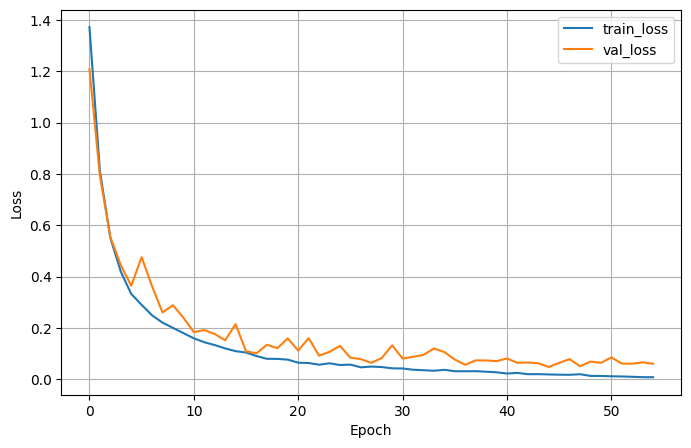

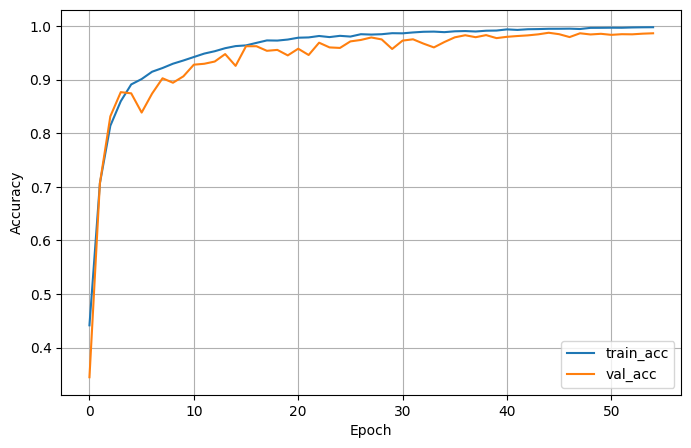

In [ ]:
NUM_CLASSES = int(y_train.max()) + 1  # đảm bảo đúng 4/5 theo nhãn sau reduce

model = Anomaly_Classifier(input_size=1, num_classes=NUM_CLASSES).to(device)

# Giữ nguyên loss phù hợp đầu ra model của bạn:
criterion = nn.NLLLoss()           # nếu model trả LogSoftmax
# criterion = nn.CrossEntropyLoss()  # nếu model trả logits

optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
model, hist = train_model(
    dataloader, model, criterion, optimizer,
    n_epochs=70, print_every=1, validation=True,
    save_best_to="checkpoints/best.pth",
    monitor="val_acc", mode="max",
    early_stopping_patience=10,
    use_amp=True, grad_clip=None,     # có thể set grad_clip=1.0 nếu loss dễ nổ
    plot_results=True
)


### Evaluation

C:\Users\dellc\AppData\Local\Temp\ipykernel_4216\3914752802.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best.load_state_dict(torch.load("checkpoints/best.pth", map_

Evaluating....
TEST ACC: 0.9912268486283248
              precision    recall  f1-score   support

           N       1.00      0.99      0.99     17939
           S       0.86      0.99      0.92       477
           V       0.96      0.99      0.98      1365
           F       0.81      0.96      0.88       157
           Q       1.00      1.00      1.00      1605

    accuracy                           0.99     21543
   macro avg       0.93      0.99      0.95     21543
weighted avg       0.99      0.99      0.99     21543



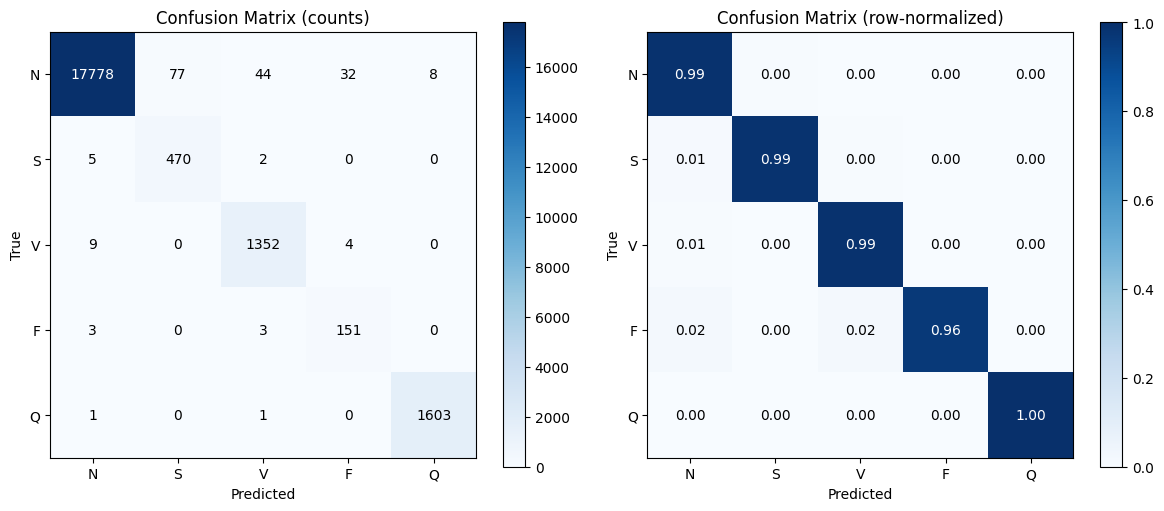

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Ánh xạ nhãn -> tên lớp AAMI (theo repo này)
# 0:N (Normal), 1:S (Supraventricular), 2:V (Ventricular), 3:F (Fusion), 4:Q (Unclassifiable)
CLASS_NAMES = ['N','S','V','F','Q']

# dùng model tốt nhất
best = Anomaly_Classifier(input_size=1, num_classes=len(CLASS_NAMES)).to(device)
best.load_state_dict(torch.load("checkpoints/best.pth", map_location=device))
best.eval()

# chạy evaluate để lấy preds/truth
preds, truth = evaluate(testloader, best, verbose=False)  # đã in ACC trong evaluate nếu bạn bật verbose=True

# ---- In classification report như hình cũ ----
print("Evaluating....")

print("TEST ACC:", accuracy_score(truth, preds))
print(classification_report(truth, preds,
                            target_names=CLASS_NAMES,
                            digits=2))

# ---- (tuỳ chọn) Vẽ confusion matrix ----
cm = confusion_matrix(truth, preds, labels=list(range(len(CLASS_NAMES))))

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# raw
im = ax[0].imshow(cm, cmap='Blues')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(np.arange(len(CLASS_NAMES))); ax[0].set_xticklabels(CLASS_NAMES)
ax[0].set_yticks(np.arange(len(CLASS_NAMES))); ax[0].set_yticklabels(CLASS_NAMES)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, cm[i, j], ha='center', va='center',
                   color='white' if cm[i,j] > cm.max()/2 else 'black')
fig.colorbar(im, ax=ax[0])

# normalized by rows (recall)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
im2 = ax[1].imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(np.arange(len(CLASS_NAMES))); ax[1].set_xticklabels(CLASS_NAMES)
ax[1].set_yticks(np.arange(len(CLASS_NAMES))); ax[1].set_yticklabels(CLASS_NAMES)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center',
                   color='white' if cm_norm[i,j] > 0.5 else 'black')
fig.colorbar(im2, ax=ax[1])

plt.tight_layout(); plt.show()


### Nạp lại Checkpoint

In [32]:
import os, torch

ckpt_path = "checkpoints/best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Khởi tạo model với đúng NUM_CLASSES đã train (thường = 5)
NUM_CLASSES = 5  # thay bằng đúng giá trị bạn đã dùng khi train

model = Anomaly_Classifier(input_size=1, num_classes=NUM_CLASSES)

# 2) Load state_dict trên CPU để tránh dính context CUDA cũ
state = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state)

# 3) Di chuyển model sang GPU (nếu có)
model = model.to(device)
model.eval()

# 4) Đánh giá
with torch.no_grad():
    preds, truth = evaluate(testloader, model, verbose=True)


C:\Users\dellc\AppData\Local\Temp\ipykernel_4216\1286108026.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")



Evaluating....
TEST ACC: 0.9912268486283248
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17939
           1       0.86      0.99      0.92       477
           2       0.96      0.99      0.98      1365
           3       0.81      0.96      0.88       157
           4       1.00      1.00      1.00      1605

    accuracy                           0.99     21543
   macro avg       0.93      0.99      0.95     21543
weighted avg       0.99      0.99      0.99     21543



### Lưu file ở dạng TorchScript(.pt) và ONNX(.onnx)

In [33]:
import os, torch
os.makedirs("checkpoints", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) Định nghĩa lại class Anomaly_Classifier (y hệt lúc train)
# >>> DÁN class Anomaly_Classifier của bạn vào đây <<<

# 2) Khởi tạo & nạp checkpoint tốt nhất trên CPU (an toàn), rồi chuyển sang device
NUM_CLASSES = 5  # đổi đúng theo bài của bạn
ckpt_path = "checkpoints/best.pth"

model = Anomaly_Classifier(input_size=1, num_classes=NUM_CLASSES)
state = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state)
model = model.to(device).eval()

print("Loaded:", ckpt_path)


Device: cuda
Loaded: checkpoints/best.pth


C:\Users\dellc\AppData\Local\Temp\ipykernel_4216\2766622610.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


In [34]:
# ví dụ cửa sổ 187 mẫu (giống pipeline train). Nếu bạn dùng AdaptivePool thì vẫn OK.
EXAMPLE_LEN = 187
example = torch.randn(1, 1, EXAMPLE_LEN).to(device)

# a) Tracing (nhanh và phù hợp conv1d)
ts_model = torch.jit.trace(model, example)
ts_path = "checkpoints/ecg1dcnn_ts.pt"
ts_model.save(ts_path)
print("Saved TorchScript to:", ts_path)

# (tuỳ chọn) Kiểm nhanh forward
with torch.no_grad():
    y = ts_model(example)
print("TorchScript output shape:", tuple(y.shape))


Saved TorchScript to: checkpoints/ecg1dcnn_ts.pt
TorchScript output shape: (1, 5)


In [36]:
%pip install -q onnx
import onnx

onnx_path = "checkpoints/ecg1dcnn.onnx"
dummy = torch.randn(1, 1, EXAMPLE_LEN).to(device)

torch.onnx.export(
    model,
    dummy,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],         # nếu model trả LogSoftmax thì tên này vẫn OK (ý nghĩa là đầu ra cuối)
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},  # batch linh hoạt
    opset_version=13,
    do_constant_folding=True
)
print("Saved ONNX to:", onnx_path)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\dellc\AppData\Roaming\Python\Python312\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  res = process_handler(cmd, _system_body)
C:\Users\dellc\AppData\Roaming\Python\Python312\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  res = process_handler(cmd, _system_body)
C:\Users\dellc\AppData\Roaming\Python\Python312\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  res = process_handler(cmd, _system_body)


Note: you may need to restart the kernel to use updated packages.
Saved ONNX to: checkpoints/ecg1dcnn.onnx


### Lưu X_test, y_test ra file

In [25]:
import numpy as np, os
os.makedirs("checkpoints", exist_ok=True)
np.savez_compressed("checkpoints/test_split.npz", X_test=X_test, y_test=y_test)
print("Saved:", "checkpoints/test_split.npz", dict(X_test=X_test.shape, y_test=y_test.shape))


Saved: checkpoints/test_split.npz {'X_test': (21543, 187), 'y_test': (21543,)}
